In [78]:
import os
import re
import random
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from scripts.data_cleaning import clean_data

In [136]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [138]:
# clean data 
train.set_index("id", inplace=True)
test.set_index("id", inplace=True)
cleaned_train_orig = clean_data(train)
cleaned_test_orig = clean_data(test)

In [139]:
# imp col
imp_col = ['designation', 'product_pitched', 'monthly_income', 'children', 'age',
       'marital_status', 'city_tier', 'number_of_followups',
       'pitch_satisfaction_score', 'typeof_contact', 'passport', 'gender'] 
#['city_tier', 'designation', 'product_pitched', 'marital_status',
#        'occupation', 'children', 'pitch_satisfaction_score', 'monthly_income',
#        'passport', 'number_of_followups', 'age']




In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    """ref :https://www.kaggle.com/code/ryanholbrook/mutual-information

    """
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [141]:
y = cleaned_train_orig['prod_taken']
cleaned_train = cleaned_train_orig[imp_col]
cleaned_test = cleaned_test_orig[imp_col]
# X = cleaned_train.drop(columns=["prod_taken"], axis=1)
X = cleaned_train

<AxesSubplot:>

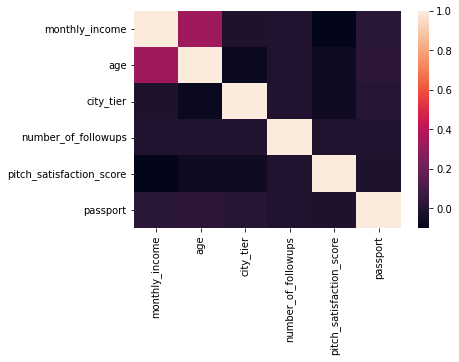

In [142]:
sns.heatmap(cleaned_train.corr(),)

In [148]:
def create_feat(train, test):
    CAT_COL =  list(test.select_dtypes(include="object").columns)
    GRP_COL = ['passport', 'city_tier','gender', 
               'designation', 'marital_status',  'children']
    def scale(X):
#         X["age"] = X["age"]//10.0
        X["age_2"] = X["age"]**2
        X["monthly_income_2"] = X["monthly_income"] **2
        X["monthly_income_log"] = X["monthly_income"].apply(np.log)
        X["age_log"] = X["age"].apply(np.log)
#         X["duration_of_pitch_log"] = X["duration_of_pitch"].apply(np.log)
        X["salary_age"] = X["monthly_income"]/X["age"]
        
        return X
    
    
#     train[CAT_COL] = train[CAT_COL].fillna(train.mode())
#     test[CAT_COL] = test[CAT_COL].fillna(train.mode())
    # create groupby feat
    for col in GRP_COL:
        for col2 in ["age", "monthly_income"]:
           train[f"{col2}_by_{col}"] =  train[col].map(train.groupby(col)[col2].mean())
           train[f"{col2}_by_{col}_diff"] = train[col2] - train[f"{col2}_by_{col}"]
            
           test[f"{col2}_by_{col}"] =  test[col].map(train.groupby(col)[col2].mean())
           test[f"{col2}_by_{col}_diff"] = test[col2] - test[f"{col2}_by_{col}"]
    
    # mathmatical transform
    train = scale(train)
    test = scale(test)
    
    # dummy variable
    train = pd.concat([pd.get_dummies(train[CAT_COL]), train], axis=1)
    test = pd.concat([pd.get_dummies(test[CAT_COL]), test], axis=1)
    
    
    
    train.drop(columns=CAT_COL, axis=1, inplace=True)
    test.drop(columns=CAT_COL, axis=1, inplace=True)
    
    
    train = train.fillna(train.mean())
    test = test.fillna(train.mean())
    return train, test
    
    
    

In [149]:






# for colname in CAT_COL:
#     X[f"{colname}_encoded"], _ = X[colname].factorize()



In [197]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from imblearn.over_sampling import SMOTE, SMOTENC
import xgboost as xgb
skf = StratifiedKFold(n_splits=5, random_state=1971, shuffle=True)

models = []
val_scores = []
oof_pred = np.zeros(len(X))
# smote = RandomOverSampler(random_state=42)
CAT_COL  = X.select_dtypes(include=['object', 'category']).columns
categorical_indices = [X.columns.get_loc(col) for col in CAT_COL]
smote = SMOTENC(categorical_features=categorical_indices, random_state=0)

for col in CAT_COL:
    X[col] = X[col].fillna(X[col].mode()[0])
X = X.fillna(X.mean())


for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    

    X_train, X_valid, y_train, y_valid = X.loc[train_index], X.loc[valid_index], y.loc[train_index], y.loc[valid_index]
#     model = make_pipeline(MinMaxScaler(), LogisticRegression())
#     model =  xgb.XGBClassifier(max_depth=5, objective="binary:logistic",booster="gbtree",learning_rate=0.1,  eval_metric="auc", random_state=42)
    
#     X_train, y_train = smote.fit_resample(X_train, y_train)
    # Check the class distribution after SMOTE
#     print("Class distribution before SMOTE:", y_train.value_counts())
#     print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())
    # feature eng
    X_train, X_valid = create_feat(X_train, X_valid)
    ###################################################################
#     model.fit(X_train, y_train)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10)
    models.append(model)
    train_pred = model.predict_proba(X_train)
    train_score = roc_auc_score(y_train, train_pred[:, 1])
    
    pred = model.predict_proba(X_valid)
    oof_pred[valid_index] = pred[:, 1]
    val_score = roc_auc_score(y_valid, pred[:, 1])
    
    val_scores.append(val_score)
    
    print(f"Fold {i}: train score {train_score} val score: {val_score}")
    
print("val score (avg)", np.mean(val_scores))
print("oof",  roc_auc_score(y, oof_pred))

[0]	validation_0-auc:0.76565
[1]	validation_0-auc:0.76430
[2]	validation_0-auc:0.76774
[3]	validation_0-auc:0.76877
[4]	validation_0-auc:0.76852
[5]	validation_0-auc:0.78208
[6]	validation_0-auc:0.78274
[7]	validation_0-auc:0.78466
[8]	validation_0-auc:0.78639
[9]	validation_0-auc:0.78705
[10]	validation_0-auc:0.78802
[11]	validation_0-auc:0.78815
[12]	validation_0-auc:0.78835
[13]	validation_0-auc:0.78900
[14]	validation_0-auc:0.79242
[15]	validation_0-auc:0.79199
[16]	validation_0-auc:0.79564
[17]	validation_0-auc:0.79964
[18]	validation_0-auc:0.80279
[19]	validation_0-auc:0.80268
[20]	validation_0-auc:0.80374
[21]	validation_0-auc:0.80326
[22]	validation_0-auc:0.80275
[23]	validation_0-auc:0.80220
[24]	validation_0-auc:0.80469
[25]	validation_0-auc:0.80478
[26]	validation_0-auc:0.80518
[27]	validation_0-auc:0.80673
[28]	validation_0-auc:0.80560
[29]	validation_0-auc:0.80482
[30]	validation_0-auc:0.80569
[31]	validation_0-auc:0.80542
[32]	validation_0-auc:0.80598
[33]	validation_0-au

In [192]:
X_valid.columns

Index(['designation_avp', 'designation_executive', 'designation_manager',
       'designation_senior manager', 'designation_vp', 'product_pitched_basic',
       'product_pitched_deluxe', 'product_pitched_king',
       'product_pitched_standard', 'product_pitched_super deluxe',
       'children_1 Children', 'children_2 Children', 'children_3 Children',
       'children_No Children', 'children_unknown', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Unmarried', 'typeof_contact_Company Invited',
       'typeof_contact_Self Enquiry', 'gender_female', 'gender_male',
       'monthly_income', 'age', 'city_tier', 'number_of_followups',
       'pitch_satisfaction_score', 'passport', 'age_by_passport',
       'age_by_passport_diff', 'monthly_income_by_passport',
       'monthly_income_by_passport_diff', 'age_by_city_tier',
       'age_by_city_tier_diff', 'monthly_income_by_city_tier',
       'monthly_income_by_city_tier_diff', 'age_by_

In [176]:
pred_label = oof_pred>=.5
pred_label = pred_label.astype('int')
wrongly_predicted_indices = np.where(pred_label != y)[0]

# Output the wrongly predicted indices
print("len of wrongly predicted samples:", len(wrongly_predicted_indices))

len of wrongly predicted samples: 875


In [177]:
cleaned_train_orig.loc[wrongly_predicted_indices]["prod_taken"].value_counts()

0    711
1    164
Name: prod_taken, dtype: int64

In [178]:
# cleaned_train["prod_taken"].value_counts()

In [179]:
# cleaned_train.describe()

(array([2445.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1044.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

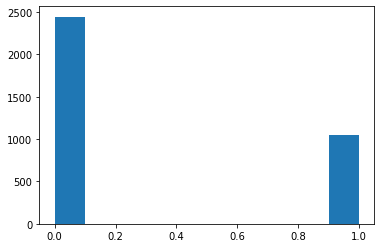

In [180]:
plt.hist(pred_label)

In [181]:
oof_pred

array([0.77555292, 0.46321854, 0.35356239, ..., 0.2617469 , 0.19127307,
       0.77619719])

In [182]:
test_X = cleaned_test
_, test_X = create_feat(X, test_X)

In [183]:
# val_scores

In [184]:
weighted_val = val_scores /np.sum(val_scores)

predict = np.zeros((len(test_X), 2))

for model, weight in zip(models,weighted_val):
    predict += weight*model.predict_proba(test_X)

In [185]:
submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit[1] = predict[:, 1]
submit.to_csv("submission.csv", index=False, header=None)

In [186]:
sum(submit.loc[:, 1]> .5)

697

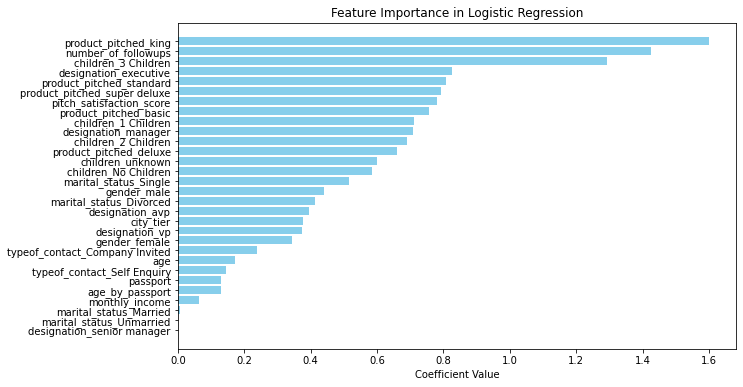

In [187]:
coefficients = model[1].coef_[0][:30]
feature_names = test_X.columns[:30]

# Create a dataframe for coefficients and sort by absolute value
importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance['AbsCoefficient'] = np.abs(importance['Coefficient'])
importance = importance.sort_values(by='AbsCoefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['AbsCoefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
feature_names

In [ ]:
# cleaned_train.sort_values("monthly_income")

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3489 non-null   float64
 1   typeof_contact             3489 non-null   object 
 2   city_tier                  3489 non-null   int64  
 3   duration_of_pitch          3489 non-null   float64
 4   occupation                 3489 non-null   object 
 5   gender                     3489 non-null   object 
 6   number_of_person_visiting  3489 non-null   float64
 7   number_of_followups        3489 non-null   float64
 8   product_pitched            3489 non-null   object 
 9   preferred_property_star    3489 non-null   float64
 10  number_of_trips            3489 non-null   float64
 11  passport                   3489 non-null   int64  
 12  pitch_satisfaction_score   3489 non-null   int64  
 13  designation                3489 non-null   objec

In [33]:
X["children"].mode()[0]

'1 Children'

In [47]:
X["children"].value_counts(dropna=False)

1 Children     1588
No Children     985
2 Children      807
3 Children       72
unknown          37
Name: children, dtype: int64

In [48]:
for idx, col in X.columns:
    if col

(3489, 18)